# Traffic Sign Classification with Tensorflow


## Step 0: Load Image Dataset

In [152]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pickle
import os
from tqdm import tqdm
from zipfile import ZipFile

# Define variables
setnames = []
data     = dict()
X        = dict()
y        = dict()

path = "/home/tiwi/Documents/mldata/"
file = "traffic-signs-data.zip"


print("Filenames in data container: \n")
for filename in ZipFile(path+file).namelist():
    print(filename)
    # Create setnames from filenames: e.g. "train", "test", ...
    setnames.append(os.path.split(filename)[1].rpartition('.')[0])
    # Get full path + file for each pickle file
    with open(path + file.rpartition('.')[0] + '/' + filename, mode='rb') as f:
        data[setnames[-1]] = pickle.load(f)
        
for setname in setnames:
    X[setname], y[setname] = data[setname]['features'], data[setname]['labels']
        

Filenames in data container: 

test.p
train.p
valid.p



## Step 1: Print Dataset Information

In [153]:
classes = pd.read_csv("../CarND-Traffic-Sign-Classifier-Project/signnames.csv")
nb_classes = len(set(y["train"]))

print("Number of training examples:\t", X["train"].shape[0])
print("Number of testing examples:\t",  X["test"].shape[0])
print("Image data shape:\t\t",          X["train"].shape[1:])
print("Number of classes:\t\t",         nb_classes)

print(classes)

Number of training examples:	 34799
Number of testing examples:	 12630
Image data shape:		 (32, 32, 3)
Number of classes:		 43
    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Prior

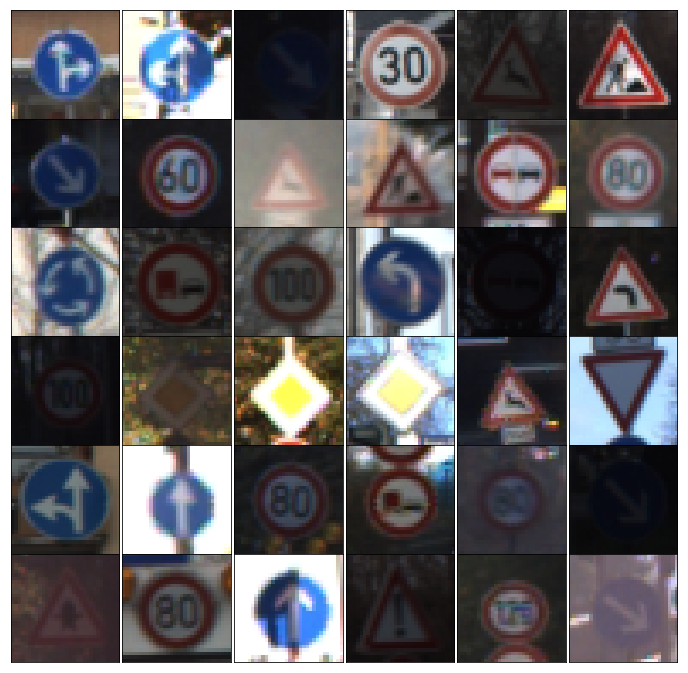

In [154]:
'''
Show all different interpolation methods for imshow
'''

import matplotlib.pyplot as plt
# Define square number of example images
n = np.int(np.floor(np.sqrt(nb_classes)))
nb_plots = n**2
random_images = [X["train"][i,::] for i in np.random.randint(0, X["train"].shape[0], nb_plots)]

# Setup a grid [n x n] grid of subplots
fig, axes = plt.subplots(n, n, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for img, ax, img_class in zip(random_images, axes.flat, classes["SignName"][0:nb_plots]):
    ax.imshow(img)
    
plt.show()



## Step 2: Design and Test a Model Architecture
The basic idea is to implement a simple CNN archictecture that gets a reasonable accurancy. But I want to try something new, therefore I'm going to reuse a pretrained model. I'll take ResNet50

### Preprocessing 1: Normalization

In [155]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder

print("Before Normalization")
print("Shape:\t", X["train"].shape)
print("Min:\t", X["train"].min())
print("Max:\t", X["train"].max())
print("Mean:\t", np.mean(X["train"]))

print("Shape y:", y["train"].shape)


def normalize(features, method='standard'):
    X = features.copy()
    if method=='standard':
        scaler = StandardScaler()
    elif method=='norm':
        scaler = Normalizer()
    elif method=='minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
        
    for key in X:
        shape      = X[key].shape
        image_size = shape[1] * shape[2] * shape[3]    
        X[key]     = X[key].reshape(-1, image_size)
        X[key]     = scaler.fit_transform(np.float32(X[key])).reshape(-1, shape[1], shape[2], shape[3])
    return X

def encode(labels):
    y = labels.copy()
    nb_classes = len(set(y["train"]))
    encoder = OneHotEncoder(sparse=False)

    for key in y:
        y[key] = encoder.fit_transform(y[key].reshape(-1, 1))
    return y

def get_batches(features, labels, batch_size):
    nb_samples = len(features)
    split_at = np.arange(batch_size, nb_samples, batch_size)
    
    features, labels = shuffle(features, labels)
    
    feature_batches = np.split(features, split_at)
    label_batches   = np.split(labels, split_at)
    
    return feature_batches, label_batches


X = normalize(X, method='minmax')
Y = encode(y)

print("\nAfter Normalization")
print("Shape:\t", X["train"].shape)
print("Min:\t", X["train"].min())
print("Max:\t", X["train"].max())
print("Mean:\t", np.mean(X["train"]))

print("Shape y:", y["train"].shape)

print("Shape Y:", Y["train"].shape)
print("Type Y:", type(Y["train"]))

assert type(Y['train']) == type(X['train'])
assert len(Y['train']) == len(y['train'])


Before Normalization
Shape:	 (34799, 32, 32, 3)
Min:	 0
Max:	 255
Mean:	 82.677589037
Shape y: (34799,)

After Normalization
Shape:	 (34799, 32, 32, 3)
Min:	 0.0
Max:	 1.0
Mean:	 0.313258
Shape y: (34799,)
Shape Y: (34799, 43)
Type Y: <class 'numpy.ndarray'>


### Model Architecture Design

In [156]:
from tensorflow.contrib.layers import flatten

def conv_relu_layer(input, kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = tf.get_variable("weights", kernel_shape, initializer=tf.random_normal_initializer())
    # Create variable named "biases".
    biases = tf.get_variable("biases", bias_shape, initializer=tf.constant_initializer(0.0))
    conv_ = tf.nn.conv2d(input, weights, strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv_ + biases)

def dense_layer(layer, output_shape, bias_shape, activation='relu'):
    
    weights_shape = [layer.shape[1], output_shape]
    dense1_W = tf.get_variable("weights", weights_shape, initializer=tf.random_normal_initializer())
    dense1_b = tf.get_variable("biases", bias_shape, initializer=tf.constant_initializer(0.0))
    dense1_   = tf.matmul(layer, dense1_W) + dense1_b 
    
    if activation=='relu':
        return tf.nn.relu(dense1_)
    elif activation=='softmax':
        return tf.nn.softmax(dense1_)
    elif activation=='none':
        return dense1_

def create_model(input_images, params, nb_classes, scope_reuse=True):
    
    nb_layers = len(params["nb_kernels"])
    
    kx   = params["kernel_size"][0][0]
    ky   = params["kernel_size"][0][1]
    nb_0 = input_images.shape[3]
    nb_1 = params["nb_kernels"][0]
    
    with tf.variable_scope("conv_layer_0", reuse=scope_reuse):
        conv = conv_relu_layer(input_images, [kx, ky, nb_0, nb_1], [nb_1])
    
    for n in range(1, nb_layers):
        nb_0 = nb_1
        kx   = params["kernel_size"][n][0]
        ky   = params["kernel_size"][n][1]
        nb_1 = params["nb_kernels"][n]
    
        with tf.variable_scope("conv_layer_"+str(n), reuse=scope_reuse):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            conv = conv_relu_layer(conv, [kx, ky, nb_0, nb_1], [nb_1])
    
    
    conv1 = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = flatten(conv1)
    with tf.variable_scope("dense_layer_0", reuse=scope_reuse):
        dense0 = dense_layer(conv2, 100, 100, activation='relu')
    
    keep_prob = tf.constant(0.25, dtype='float32')
    dense0_drop = tf.nn.dropout(dense0, keep_prob=keep_prob)
    with tf.variable_scope("dense_layer_1", reuse=scope_reuse):
        logits = dense_layer(dense0_drop, nb_classes, nb_classes, activation='none')
            
    
    return logits


### Train the Model

In [157]:
tf.reset_default_graph()
conv_params = dict({'kernel_size': [], 'nb_kernels':[]})
conv_params['kernel_size'] = [[3, 1],
                              [1, 3],
                              [3, 3],
                              [5, 5]]
conv_params['nb_kernels'] = [6,
                             6,
                             12,
                             32]    

x         = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
one_hot_y = tf.placeholder(tf.float32, shape=(None, nb_classes))

logits = create_model(x, params=conv_params, nb_classes=nb_classes, scope_reuse=False)


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.02).minimize(loss)
#optimizer = tf.train.AdadeltaOptimizer(learning_rate=1.0, rho=0.95, epsilon=1e-08).minimize(loss)

#keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

In [158]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_batches, Y_batches):
    
    total_accuracy   = 0
    nb_total_samples = 0
    sess = tf.get_default_session()
    for X_batch, Y_batch in zip(X_batches, Y_batches):
        accuracy = sess.run(accuracy_operation, feed_dict={x: X_batch, one_hot_y: Y_batch})
        
        nb_samples        = len(Y_batch)
        total_accuracy   += (accuracy * nb_samples)
        nb_total_samples += nb_samples

    return total_accuracy / nb_total_samples


In [173]:
nb_epochs = 1
nb_samples = 100
batch_size = 20
losses = []
validation_accuracy = []
X_batches, Y_batches = get_batches(X['train'][0:nb_samples,::],
                                   Y['train'][0:nb_samples,::],
                                   batch_size=batch_size)


for X_batch, Y_batch in zip(X_batches, Y_batches):
    assert(X_batch.shape[0]==batch_size)
    assert(Y_batch.shape[0]==batch_size)
    
# Add ops to save and restore all the variables.
checkpoint_file = "./checkpoints/model.ckpt"
checkpoint_path = ""
saver = tf.train.Saver()

with tf.Session() as session:
    # Restore variables from disk.
    if os.path.isfile(checkpoint_file + ".meta"):
        saver.restore(session, tf.train.latest_checkpoint('./checkpoints/'))
        print("Model restored.")
    else:
        session.run(tf.global_variables_initializer())
    for epoch in range(nb_epochs):
        print("EPOCH {} ...".format(epoch+1))
        X_batches, Y_batches = shuffle(X_batches, Y_batches)
        for X_batch, Y_batch in zip(X_batches, Y_batches):
            assert(X_batch.shape[0]==batch_size)
            assert(Y_batch.shape[0]==batch_size)
            X_batch, Y_batch = shuffle(X_batch, Y_batch)
            _,l = session.run([optimizer, loss], feed_dict={x:X_batch, one_hot_y:Y_batch})
            losses.append(l)
            print("Loss = {:.3f}".format(l))

        acc = evaluate(X_batches[0:2], Y_batches[0:2])
        validation_accuracy.append(acc)
        print("Validation Accuracy = {:.3f}".format(acc))
        # Save the variables to disk.
        checkpoint_path = saver.save(session, checkpoint_file)





Model restored.
EPOCH 1 ...
Loss = 361.888
Loss = 147.991
Loss = 189.590
Loss = 20.891
Loss = 34.466
Validation Accuracy = 0.850


In [169]:
print(checkpoint_file)
print(checkpoint_path)

print(os.path.exists(checkpoint_file + '*'))
os.path.exists('./checkpoint')


./checkpoints/model.ckpt
./checkpoints/model.ckpt
False


False

In [ ]:
plt.plot(losses)
plt.show()
print(losses)

### ToDos
* add checkpoints for reinitialization
* start with tensorboard
* augement dataset to get balanced labels distribution
* run full dataset on AWS